# Process CF Parcel-level Annotations

1. Batch 1: 5,500 residential parcels from a simple random sample (3.5%) across each of the 51 income strata
2. Batch 2: ~3,000 residential parcels matching to AANC permits
3. Batch 3: ~16,000 residential parcels (latest estimate) according Neyman allocation per the power analysis to detect a significant effect in the permitted new small building proportion in low vs. high income neighborhoods

**Outline:**

Part 1: 
- Extract CF polygons -> This gives us a map of small buildings in each year (gdf)
- Identify newly constructed small buildings (entirely new, replacement of old building)

*Part 1 outputs:*
- parcel_density: DataFrame of number of small buildings per parcel in 2016 and 2020
- CF_area_coverage: shp of the parcels annotated by CF
- sbuild_2020_compared: geoDataFrame of 2020 small buildings, including a flag for whether they are new constructions

Part 2: 
- Permit-matching for newly constructed small buildings
- Outcome analysis 

In [1]:
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [2]:
# Load functions 
%run ADU_permit_matching-polygon-pipeline.ipynb import compare_building_footprint

In [3]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
CF_FP = os.path.join(OAK_FP, 'CloudFactory')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')

# Parameters
batch = 1
completion = 48
permit_matching = ['nearest-building', 'parcel-level'][1]
max_distance = 50

In [4]:
# Input data
# * Universe of SJ res parcels assigned to each CBG
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * San Jose AANC permit data
permits = pd.read_csv(os.path.join(OAK_FP, 'outputs/Permit-Matching/outputs/all_permits.csv'))
permits['geometry_permit'] = gpd.GeoSeries.from_wkt(permits['geometry_permit'])
permits_2015_20 = permits.loc[
    permits['issue_year'].isin([2015, 2016, 2017, 2018, 2019, 2020])].copy()

# * Income-stratified CBGs (from Pop-Estimates-Strata.ipynb)
cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

In [24]:
# Inputs from part 1
CF_area_coverage = gpd.read_file(
    os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion), 'CF_area_coverage'))
sbuild_2020_compared = pd.read_csv(os.path.join(
    OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion), 'sbuild_2020_compared.csv'), 
                                   dtype={'APN': 'str'})
parcel_density = pd.read_csv(
    os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion), 'parcel_density.csv'))

In [6]:
# Functions
def snap_permits(permit_data, small_build, max_distance):
    # 0. Prepare data
    permit_data_gdf = gpd.GeoDataFrame(
        permit_data, geometry='geometry_permit', crs='EPSG:4326')
    permit_data_gdf.reset_index(inplace=True, drop=True)
    permit_data_gdf['permit_index'] = permit_data_gdf.index
    n_permits = len(permit_data_gdf)
    
    small_build.reset_index(inplace=True, drop=True)
    small_build['sbuild_index'] = small_build.index

    # 1. Assign permits to nearest small building 
    # * Create a buffer around the small building
    small_build_buff = small_build.to_crs('EPSG:26910').copy()
    small_build_buff['centroid'] = small_build_buff['geometry'].centroid
    small_build_buff['geometry'] = small_build_buff.buffer(max_distance)

    # * Join permits and small buildings
    permits_snap = permit_data_gdf[
        ['OBJECTID_left', 'issue_year', 'geometry_permit', 'permit_index']].to_crs('EPSG:26910').sjoin(
        small_build_buff[['geometry', 'centroid', 'sbuild_index']], how='left', predicate='intersects')

    # * Drop permits that do not match to buffered buildings
    permits_snap = permits_snap.loc[~permits_snap['index_right'].isna()]

    # * Compute distance
    permits_snap['distance'] = permits_snap['geometry_permit'].distance(permits_snap['centroid'])

    # * Order permits by closest distance and drop duplicates
    permits_snap.sort_values('distance', ascending=True, inplace=True)
    permits_snap.drop_duplicates(subset='permit_index', keep='first', inplace=True)
    assert len(permits_snap) <= len(permits_snap['permit_index'].unique())

    # -- 2. Define permitted new small buildings
    permits_snap['index_right'] = permits_snap['index_right'].astype(int)
    permits_snap['sbuild_index'] = permits_snap['sbuild_index'].astype(int)

    sbuild_permitted = pd.merge(
        small_build, permits_snap[['sbuild_index', 'OBJECTID_left', 'issue_year']], 
        how='left', on='sbuild_index', validate='one_to_many')
    sbuild_permitted['permitted'] = ~sbuild_permitted['OBJECTID_left'].isna()

    # Keep only one permit per building (to not duplicate small buildings)
    sbuild_permitted.sort_values('permitted', ascending=False, inplace=True)
    sbuild_permitted.drop_duplicates('sbuild_index', keep='last', inplace=True)

    return sbuild_permitted

## 1. Permit-matching
Can be performed at the parcel-level or via assigning permits to the nearest small building.

In [12]:
if permit_matching not in ['nearest-building', 'parcel-level']:
    raise Exception('[ERROR] Check permit matching type')

In [13]:
if permit_matching == 'nearest-building':
    print('[INFO] Performing permit-matching spatially via nearest small building')
    
    # Snap permits to nearest small building (within a threshold)
    snap_path = os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion),
                             'permit-matching-nearest-{}.csv'.format(max_distance)) 
    
    if not os.path.exists(os.path.dirname(snap_path)):
        os.makedirs(os.path.dirname(snap_path))
    
    if os.path.exists(snap_path):
        print('[INFO] Loading nearest-building matching using max distance of {}'.format(max_distance))
        new_sbuild_2020 = gpd.read_file(snap_path)
    else:
        # Assign permits to nearest building   
        sbuild_2020_permitted = snap_permits(
            permit_data=permits_2015_20, small_build=sbuild_2020_compared, max_distance=max_distance)
        print('[INFO] {} permits assigned to small buildings using max distance of {}'. format(
            sbuild_2020_permitted['permitted'].sum(), max_distance))
        
        # Aggregate at the parcel level (just consider parcel growth)
        new_sbuild_2020 = sbuild_2020_permitted.copy()
        new_sbuild_2020 = new_sbuild_2020.loc[new_sbuild_2020['expansion_2016_flag'] == True].copy()
        new_sbuild_2020['expansion_2016_flag'] = new_sbuild_2020['expansion_2016_flag'].astype(int)
        
        #new_sbuild_2020['permitted'] = ~new_sbuild_2020['OBJECTID_left'].isna()
        new_sbuild_2020 = new_sbuild_2020.groupby(['APN'])[
            ['expansion_2016_flag', 'permitted']].sum().reset_index()

        new_sbuild_2020.rename(
            columns={'expansion_2016_flag': 'count_new_sbuild', 
                     'permitted': 'count_new_sbuild_permitted'}, inplace=True)
        new_sbuild_2020['count_new_sbuild_unpermitted'] = new_sbuild_2020[
            'count_new_sbuild'] - new_sbuild_2020['count_new_sbuild_permitted']
        assert new_sbuild_2020['count_new_sbuild_unpermitted'].min() >= 0

        # Save
        new_sbuild_2020.to_csv(snap_path)

In [28]:
if permit_matching == 'parcel-level':
    """
    Counts the number of newly constructed small buildings and the number of AANC permits issue
    during 2015-20 to determine what proportion are permitted vs unpermitted. 
    """
    
    print('[INFO] Performs permit-matching using parcel APNs')
    
    # Get number of 2015-20 AANC permits per parcel
    parcel_permit_counts = permits_2015_20.copy()
    parcel_permit_counts = parcel_permit_counts.groupby('APN_parcel')['OBJECTID_left'].count().reset_index()
    parcel_permit_counts.rename(
        columns={'APN_parcel': 'APN', 'OBJECTID_left': 'pcount_2015_20'}, inplace=True)
    
    # Get new small building counts for each parcel
    new_sbuild_2020 = sbuild_2020_compared.loc[sbuild_2020_compared['expansion_2016_flag'] == True].copy()
    new_sbuild_2020 = new_sbuild_2020.groupby('APN')['expansion_2016_flag'].count().reset_index()
    new_sbuild_2020.rename(columns={'expansion_2016_flag': 'count_new_sbuild'}, inplace=True)
    
    # Merge permit and small building data
    new_sbuild_2020 = pd.merge(
        new_sbuild_2020, parcel_permit_counts[['APN', 'pcount_2015_20']], on='APN', 
        how='left', validate='one_to_one')

    # Fill parcel columns with zeros
    new_sbuild_2020[['pcount_2015_20']] = new_sbuild_2020[['pcount_2015_20']].fillna(value=0)

    # Compute unpermitted and permitted new small buildings at the parcel level
    new_sbuild_2020['count_new_sbuild_permitted'] = new_sbuild_2020.apply(
        lambda row: min(row['count_new_sbuild'], row['pcount_2015_20']), axis=1)
    new_sbuild_2020['count_new_sbuild_unpermitted'] = new_sbuild_2020[
        'count_new_sbuild'] - new_sbuild_2020['count_new_sbuild_permitted']

    assert new_sbuild_2020['count_new_sbuild_unpermitted'].sum() + new_sbuild_2020[
        'count_new_sbuild_permitted'].sum() == new_sbuild_2020['count_new_sbuild'].sum()
    
    new_sbuild_2020.to_csv(os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion),
                         'permit-matching-apns.csv'), index=False)

[INFO] Performs permit-matching using parcel APNs


In [15]:
# Print stats
print('[INFO] Permitted small building constructions: {}'.format(
    new_sbuild_2020['count_new_sbuild_permitted'].sum() ))
print('[INFO] Unermitted small building constructions: {}'.format(
    new_sbuild_2020['count_new_sbuild_unpermitted'].sum() ))
print('[INFO] Total small building constructions: {}'.format(
    new_sbuild_2020['count_new_sbuild'].sum() ))

[INFO] Permitted small building constructions: 5.0
[INFO] Unermitted small building constructions: 45.0
[INFO] Total small building constructions: 50


## 2. Outcome analysis (equity impact)

In [29]:
# Generate quartile and neighborhood columns for each CBG
if 'neighborho' in cbg_income_2016_SJ.columns:
    cbg_income_2016_SJ.drop('neighborho', axis=1, inplace=True)

quartile_neighborhoods = {'IS_0': 'Low', 'IS_1': 'Low', 'IS_2': 'Low', 'IS_3': 'High'}
quartile_names = {'IS_0': 'Low', 'IS_1': 'Low-Moderate', 'IS_2': 'High-moderate', 'IS_3': 'High'}

cbg_income_2016_SJ['quartile'] = pd.qcut(
    cbg_income_2016_SJ['median_inc'], q=4, 
    labels=['IS_{}'.format(i) for i in range(4)])

cbg_income_2016_SJ['neighborhood'] = cbg_income_2016_SJ['quartile'].apply(
    lambda quartile: quartile_neighborhoods[quartile])

cbg_income_2016_SJ['quartile'] = cbg_income_2016_SJ['quartile'].apply(
    lambda quartile: quartile_names[quartile])

sj_parcels_cbgs = pd.merge(
    sj_parcels_cbgs, cbg_income_2016_SJ[['GEOID', 'neighborhood', 'quartile']], how='left', 
    validate='many_to_one')

# Add GEOID, neighborhood and quartile
outcome = new_sbuild_2020.copy()
outcome = pd.merge(
    outcome, sj_parcels_cbgs[['APN', 'GEOID', 'neighborhood', 'quartile']], 
    how='left', validate='one_to_one')

At the quartile level
        quartile  count_new_sbuild_permitted  count_new_sbuild_unpermitted  \
0            Low                         2.0                           9.0   
1   Low-Moderate                         1.0                           7.0   
2  High-moderate                         0.0                          16.0   
3           High                         2.0                          13.0   

   total_change  permitted_proportion  
0          11.0              0.181818  
1           8.0              0.125000  
2          16.0              0.000000  
3          15.0              0.133333  


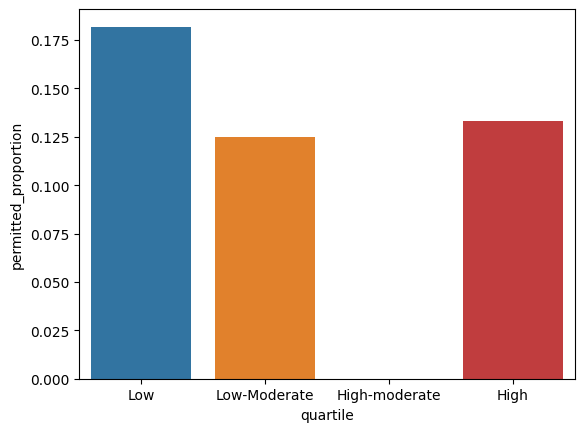

In [30]:
# Aggregate by quartile
outcome_quartile = outcome.groupby('quartile')[
    ['count_new_sbuild_permitted', 'count_new_sbuild_unpermitted']].sum().reset_index()

outcome_quartile['total_change'] = outcome_quartile['count_new_sbuild_permitted'] + outcome_quartile[
    'count_new_sbuild_unpermitted']
outcome_quartile['permitted_proportion'] = outcome_quartile.apply(
    lambda row: row['count_new_sbuild_permitted'] / row['total_change'], axis=1)

print('At the quartile level')
print(outcome_quartile)
sns.barplot(outcome_quartile, x='quartile', y='permitted_proportion')
plt.show()

In [31]:
print('[INFO] {} small buildings in 2020; {} newly constructed small buildings in 2020'.format(
    len(sbuild_2020_compared), sbuild_2020_compared['expansion_2016_flag'].sum()))

print('[INFO] {} permits issued during 2015-20'.format(len(permits_2015_20)))

print('[INFO] Number of permitted new small buildings: {}'.format(
    new_sbuild_2020['count_new_sbuild_permitted'].sum()))

[INFO] 585 small buildings in 2020; 50 newly constructed small buildings in 2020
[INFO] 5140 permits issued during 2015-20
[INFO] Number of permitted new small buildings: 5.0


## 3. Power analysis inputs

### 3.1 SRS

In [32]:
# Compute new small buildings across all annotated parcels
sb_growth = sbuild_2020_compared.copy()
sb_growth['expansion_2016_flag'] = sb_growth['expansion_2016_flag'].astype(int)
sb_growth = sb_growth.groupby('APN')['expansion_2016_flag'].sum().reset_index()

sb_growth = pd.merge(parcel_density, sb_growth, on='APN', how='left', validate='one_to_one')
sb_growth.fillna(0, inplace=True)

In [33]:
# Add GEOID
sb_growth = pd.merge(sb_growth, sj_parcels_cbgs[['APN', 'GEOID']], how='left', validate='one_to_one')

# Add neighborhood
high_income_cbgs = cbg_income_2016_SJ.loc[cbg_income_2016_SJ['neighborhood'] == 'High']['GEOID'].unique()
print('Number of high income CBGS (defined by 75%): {}'.format(len(high_income_cbgs)))

sb_growth['neighborhood'] = sb_growth['GEOID'].apply(
    lambda geoid: 'high' if geoid in high_income_cbgs else 'low')

sb_growth.groupby(['neighborhood', 'expansion_2016_flag'])['APN'].count().reset_index()

Number of high income CBGS (defined by 75%): 160


,neighborhood,expansion_2016_flag,APN
0,high,0.0,856
1,high,1.0,15
2,low,0.0,1760
3,low,1.0,35


### 3.2 Neyman

In [80]:
# Load parcel confidences and subset to CF area
parcel_conf_df = pd.read_csv(
    os.path.join(OUTPUT_FP, 'Confidences', 'parcel-confidence.csv'), 
    dtype={'GEOID': str})  

new_sbuild_2020 = pd.read_csv(
    os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion), 'permit-matching-apns.csv'), 
dtype={'APN': 'str'})

parcel_conf_df = parcel_conf_df.loc[parcel_conf_df['APN'].isin(CF_area_coverage['APN'].unique())]

In [81]:
# Add high/low neighborhood (defined by 75 percentile)
parcel_conf_df = pd.merge(
    parcel_conf_df, cbg_income_2016_SJ[['GEOID', 'neighborhood']], how='left', 
    validate='many_to_one')

parcel_conf_df['neighborhood(75)'] = parcel_conf_df['neighborhood']

In [82]:
# Generate income-confidence bins: we cut parcel confidences into low confidence (< 0.5) and
# high confidence (> 0.5)
parcel_conf_df['CBin'] = pd.cut(parcel_conf_df['confidence'], bins=2, labels=False)
parcel_conf_df['CBin'] = parcel_conf_df['CBin'].fillna(value= 'None')

parcel_conf_df['Bin'] = parcel_conf_df.apply(
    lambda row: '{}-{}'.format(row['strata_inc'], row['CBin']), axis=1)

In [84]:
# Add Y_ij
# Y_ij is the permitted proportion of new small buildings in the parcel. We use
# a value of 0 if there were no new small buildings between 2016 and 2020. 
new_sbuild_2020['permitted_ratio'] = new_sbuild_2020.apply(
    lambda row: 0 if row['count_new_sbuild'] == 0  else row['count_new_sbuild_permitted'] / row['count_new_sbuild'], 
    axis=1)

Y_ij = new_sbuild_2020[['APN', 'permitted_ratio']]

parcel_conf_df = pd.merge(parcel_conf_df, Y_ij, how='left', validate='one_to_one')

# Need to fill with zeros because new_sbuild_2020 only contains parcels with new small buildings
parcel_conf_df['permitted_ratio'] = parcel_conf_df['permitted_ratio'].fillna(0)

In [93]:
# Add parcel new small buildings
parcel_conf_df = pd.merge(
    parcel_conf_df, new_sbuild_2020[['APN', 'count_new_sbuild']], how='left', validate='one_to_one')

# Again we need to fill with zeros
parcel_conf_df['count_new_sbuild'] = parcel_conf_df['count_new_sbuild'].fillna(0)

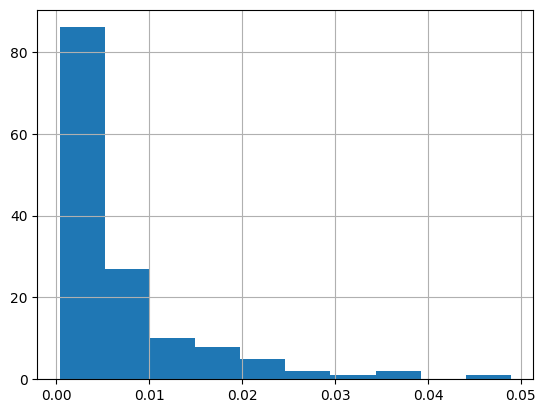

In [110]:
# Find S_j, N_j
Neyman_alloc = parcel_conf_df.groupby('Bin').agg(
    {'APN': 'count', 'permitted_ratio': 'std'}).reset_index()
Neyman_alloc.rename(columns={'APN': 'N_j', 'permitted_ratio': 'S_j'}, inplace=True)

# Smoothing: as may parcels did not have new buildings, we set S_j = min(S_j, min S_i), 
# where S_i > 0 so that each bin has a non-zero probability of being sampled from.
min_Sj = Neyman_alloc.loc[Neyman_alloc['S_j'] > 0]['S_j'].min()
Neyman_alloc['S_j'] = Neyman_alloc['S_j'].apply(
    lambda sj: sj if sj > 1e-5 else min_Sj)

Neyman_denom = (Neyman_alloc['N_j'] * Neyman_alloc['S_j']).sum()
Neyman_alloc['weight'] = Neyman_alloc.apply(
    lambda row: row['N_j'] * row['S_j'] / Neyman_denom, axis=1)

Neyman_alloc['weight'].hist()
plt.show()

assert Neyman_alloc['weight'].sum() - 1 < 1e-5

In [113]:
# Save
Neyman_alloc.to_csv(
    os.path.join(OUTPUT_FP, 'CF-Annotation-Outputs', 'B{}-{}'.format(batch, completion),
                 'PA-neyman_alloc.csv'), index=False)
parcel_conf_df.to_csv(os.path.join(
    OUTPUT_FP, 'CF-Annotation-Outputs', 'B{}-{}'.format(batch, completion),
    'PA-CFparcels.csv'), index=False)

## 6. Explore

In [107]:
50 / 2666 * 150000

2813.2033008252065

False positives in CF annotations
We see 67 permits that go unmatched in the area for B1-48. 

In [112]:
#fp = gpd.clip(gpd.GeoDataFrame(permits_2015_20, geometry='geometry_permit', crs='EPSG:4326'), 
#              CF_area_coverage)

In [60]:
fp = permits_2015_20.loc[permits_2015_20['APN_parcel'].isin(CF_area_coverage['APN'].unique())]
fp = fp[['ADDRESS', 'APN_parcel', 'WORKDESC', 'issue_year', 
         'PERMITVALUE', 'SQUAREFOOT', 'geometry_permit']]
fp['coords'] = fp['geometry_permit'].apply(
    lambda geom: '{}, {}'.format(list(geom.coords)[0][1], list(geom.coords)[0][0]))

In [61]:
# Remove permits we did match to small building constructions
print(len(fp))
perm = new_sbuild_2020.loc[new_sbuild_2020['count_new_sbuild_permitted'] > 0]
fp = fp.loc[~fp['APN_parcel'].isin(perm['APN'].unique())]
print(len(fp))

73
67


In [63]:
fp.loc[fp['SQUAREFOOT'] >0]

,ADDRESS,APN_parcel,WORKDESC,issue_year,PERMITVALUE,SQUAREFOOT,geometry_permit,coords
36,"1737 LAURELWOOD DR , SAN JOSE CA 95125-4952",44609018,Additions/Alterations,2020,251681.0,916,POINT (-121.91122 37.28291),"37.28290500025418, -121.91121900033804"
205,"1561 VIRGINIA PL 2 , SAN JOSE CA 95116",48145016,New Construction,2020,79966.0,653,POINT (-121.85219 37.34367),"37.343672999735396, -121.85218799981378"
9119,"2658 HILL PARK DR , SAN JOSE CA 95124-1734",44228004,Additions/Alterations,2015,2450.0,196,POINT (-121.91439 37.27442),"37.27441800043732, -121.91438699981035"
9629,"1532 NEWPORT AV , SAN JOSE CA 95125-3331",42930012,Additions/Alterations,2016,31304.0,307,POINT (-121.89902 37.29959),"37.299591000038184, -121.89901949948533"
9788,"7078 BOLLINGER RD , SAN JOSE CA 95129-2849",37201030,Additions/Alterations,2015,227033.0,2228,POINT (-122.02846 37.31111),"37.311111000061764, -122.02846199998216"
10459,"1810 GREENCREEK DR , SAN JOSE CA 95124-1120",44208047,Additions/Alterations,2017,24951.0,511,POINT (-121.92121 37.28098),"37.28097900013743, -121.9212135003063"
10827,"2285 COTTLE AV , SAN JOSE CA 95125-4004",43931006,Additions/Alterations,2018,45855.0,450,POINT (-121.89344 37.28670),"37.28670300015123, -121.89344399963171"
10916,"943 RIVERSIDE DR , SAN JOSE CA 95125-2269",26452076,Additions/Alterations,2018,22928.0,225,POINT (-121.90246 37.31451),"37.31451300000566, -121.90246200019135"
11065,"1399 OAK KNOLL DR , SAN JOSE CA 95129-4171",37817045,Additions/Alterations,2018,41371.0,406,POINT (-121.99980 37.29775),"37.2977459997791, -121.99980149994019"
11222,"2258 WALNUT GROVE AV , SAN JOSE CA 95128-1240",27432041,Additions/Alterations,2018,30118.0,195,POINT (-121.94241 37.33327),"37.33326900037005, -121.94240850017138"
